In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import sqlite3
import plotly.express as px
import os, sys, glob

In [84]:
#užduotis :
# ar yra priklausomybė tarp paradvėjo vietovėje 
# esančio vidutinio atlyginimo ir parduodamo automobilio kainos?
#panaudokite regplot.

In [85]:
DB = sqlite3.connect('../DATA/WEBscr.db')
C = DB.cursor()

#sql užklausa per pandas sql_query
sql="""select * from TAutos"""
dfautos = pd.read_sql_query(sql, con=DB)

#sql užklausa per pandas sql_query
sql="""select * from TUrl"""
dfurl = pd.read_sql_query(sql, con=DB)
dfurl.head()

C.close()
DB.close()

In [86]:
def getplpr(x:str) -> tuple[str, float]:
    *_, pl, pr = x.split(';')
    pl = pl.strip()
    if pr.count('€') > 1:
        p1, *_, p2 = pr.strip().split('\n')
        pr = float(p2.replace('€','').replace(' ',''))
    else:
        pr = float(pr.replace('€','').replace(' ',''))
    return pl, pr

places, places_short, prices = [], [], []
for f in dfurl['params'].values:
    p, r = getplpr(str(f))
    places_short.append(p[:4])
    places.append(p)
    prices.append(r)
    
df = dfurl[['id', 'params']]
df['PL'] = places
df['PLC'] = places_short
df['PR'] = prices

In [87]:
dfa = pd.read_csv('../DATA/atlyginimai.csv')
dfa = dfa[['Sav.', 'Bruto, EUR']]
dfa.columns = ['Sav', 'Eur']
dfa['Sav'] = dfa['Sav'].str[:4]
dfa.drop_duplicates(subset=['Sav'], inplace=True)
dfa['Eur'] = dfa['Eur'].str.replace(' ','').str.replace(',','.').str.replace('\xa0','').apply(float)

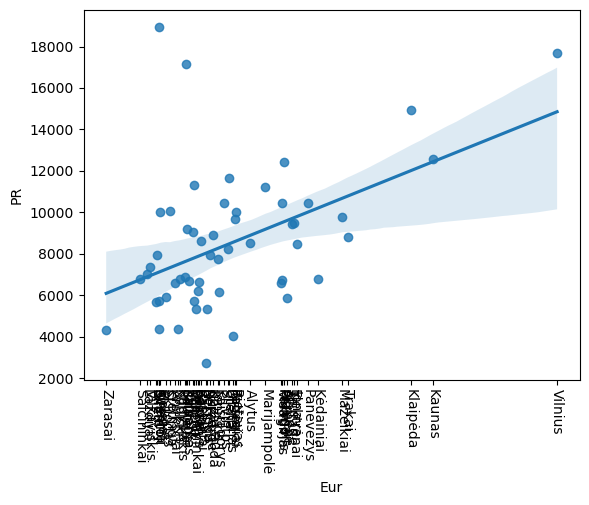

In [88]:
dfs = pd.merge(left=df, right=dfa, left_on='PLC', right_on='Sav')
dfgr = dfs.groupby('PL').mean(numeric_only=True).reset_index()
vs = dfgr[['PL', 'Eur']].sort_values(by='Eur')
ax = sns.regplot(data=dfgr, x='Eur',y='PR')
vs.head(1)
ax.set_xticks(vs['Eur'].values.tolist())
ax.set_xticklabels(vs['PL'].values.tolist())
ax.tick_params(axis='x', rotation=-90)
plt.show()

In [89]:
# koreliacija

In [90]:
dfgr.set_index('PL', inplace=True)
dfgr

,PR,Eur
PL,,
Akmenė,5888.727273,1758.8
Alytus,8523.221098,1685.4
Anykščiai,6621.039474,1537.7
Birštonas,11676.515152,1645.0
Biržai,5660.707547,1500.9
Druskininkai,11301.676471,1576.3
Elektrėnai,9492.321739,1772.2
Ignalina,4375.564103,1506.3
Jonava,8478.454167,1778.3


In [91]:
dfgr.corr(numeric_only=True)

,PR,Eur
PR,1.000000,0.470622
Eur,0.470622,1.000000


In [92]:
dfgr.corr(numeric_only=True, method='pearson')

,PR,Eur
PR,1.000000,0.470622
Eur,0.470622,1.000000


In [93]:
dfgr.corr(numeric_only=True, method='kendall')

,PR,Eur
PR,1.00000,0.28966
Eur,0.28966,1.00000


In [94]:
dfgr.corr(numeric_only=True, method='spearman')

,PR,Eur
PR,1.00000,0.40596
Eur,0.40596,1.00000


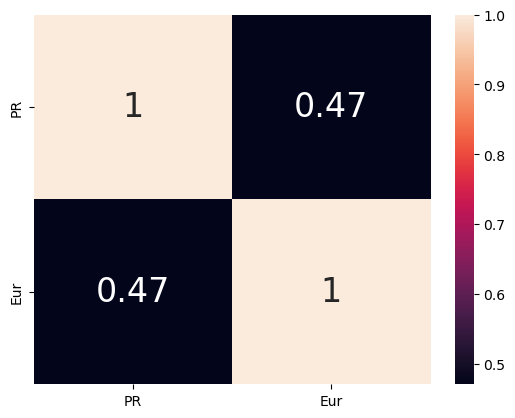

In [113]:
c = dfgr.corr(numeric_only=True, method='pearson')

ax = sns.heatmap(data=c,annot=True, annot_kws={'fontsize':24})
#ax.collections[0].colorbar.ax.tick_params(labelsize=fontsize) #uncomment to change colorbar labelsize

<AxesSubplot: xlabel='PR', ylabel='Count'>

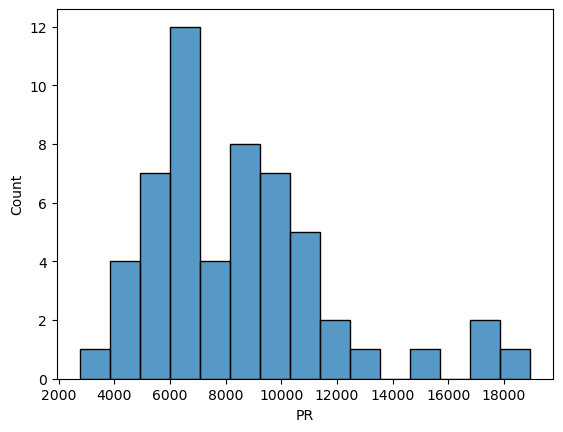

In [115]:
sns.histplot(data=dfgr, x='PR', bins=15)

<AxesSubplot: xlabel='PR', ylabel='Count'>

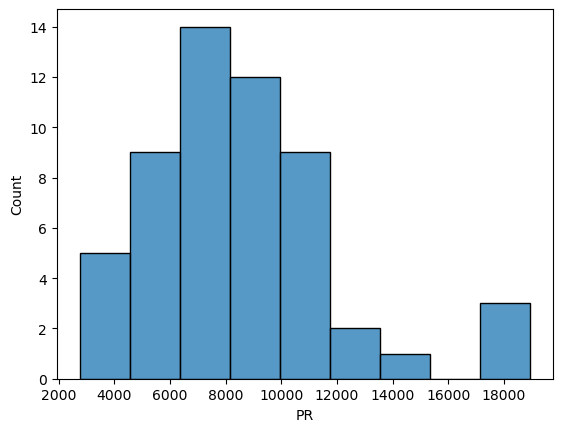

In [97]:
sns.histplot(data=dfgr, x='PR')

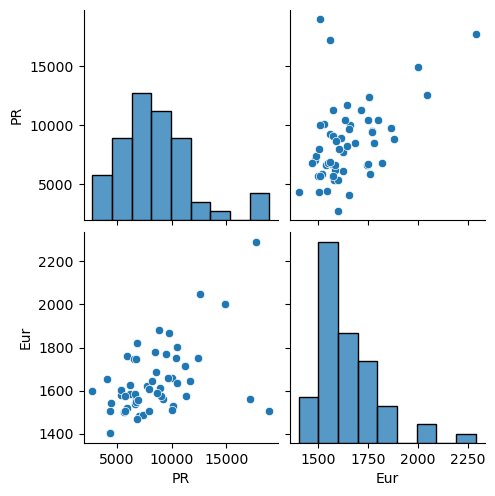

In [98]:
sns.pairplot(data=dfgr)

<AxesSubplot: ylabel='PL'>

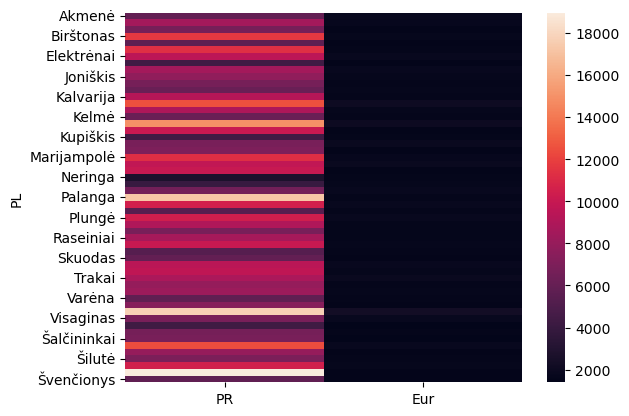

In [99]:
sns.heatmap(data=dfgr)
#ax.collections[0].colorbar.ax.tick_params(labelsize=fontsize) #uncomment to change colorbar labelsize

In [ ]:
# suraskite, ar yra koreliacija tarp šių parametrų - ridos, 
# kainos, automobilio amžiaus, variklio tūrio. Vizualizuokite tai 
# su heatmap. Su histograma atvaizduokite automobilių amžiaus pasiskirstymą. 
# ar yra priklausomybė tarp butų amžiaus ir kainos? Tarp butų 
# kambarių kiekio ir kainos? Panaudokite heatmap. Su histograma atvaizduokite
# butų plotų pasiskirstymą. 
#Panaudokite pairplot. Ką galite įžvelgti iš pairplot?

In [ ]:
# Note - su histograma - paeksperimentuokite su binwidth parametru, su bins parametru - bins parametras nurodo, 
# kiek intervalų norite turėti - skaičius čia.

In [ ]:
#Atvaizduokite top3 gamintojų skelbimų ir ridų kainų 
# pasiskirstymą su histograma. Panaudokite hue raktažodį bei multiple raktažodį,
# išbandykite 
# multiple raktažodžio galimas reikšmes. 
# Kuris histogramos variantas yra infromatyviausias?

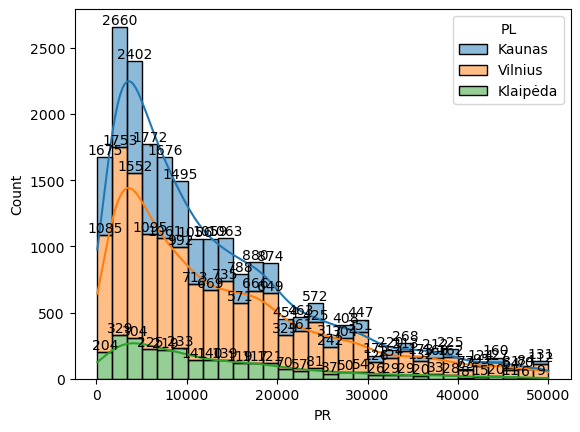

In [120]:
ax = sns.histplot(data=df[df['PL'].isin(['Vilnius','Kaunas','Klaipėda'])].query('PR < 50000'), multiple='stack', x='PR', hue='PL', bins=30, kde=True)
for c in ax.containers:
    ax.bar_label(c)
plt.show()

In [121]:
dfgr

,PR,Eur
PL,,
Akmenė,5888.727273,1758.8
Alytus,8523.221098,1685.4
Anykščiai,6621.039474,1537.7
Birštonas,11676.515152,1645.0
Biržai,5660.707547,1500.9
Druskininkai,11301.676471,1576.3
Elektrėnai,9492.321739,1772.2
Ignalina,4375.564103,1506.3
Jonava,8478.454167,1778.3


Index(['id', 'params', 'PL', 'PLC', 'PR'], dtype='object')


<AxesSubplot: xlabel='PR', ylabel='Density'>

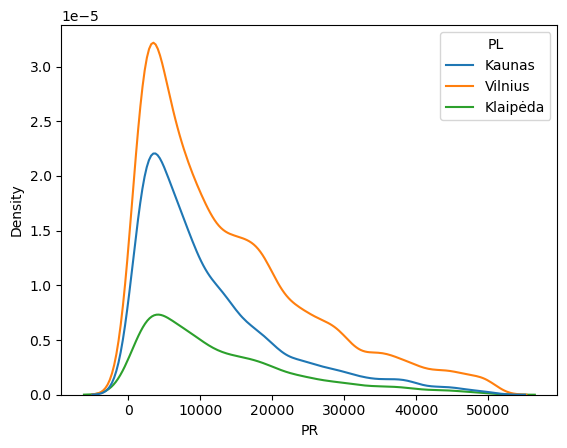

In [132]:
dd = df[df['PL'].isin(['Vilnius','Kaunas','Klaipėda'])].query('PR < 50000')
print(dd.columns)
sns.kdeplot(data=dd, x='PR', hue='PL')

In [ ]:
#Išanalizuokite elektromobilių pasiūlą - 
# ridos, amžiaus, baterijos talpos, nuvažiuojamo atstumo 
# įtaką kainai, raskite ir vizualizuokite 
# koreliacijų tarp šių parametrų dydžius. 
# Panaudokite heatmap, pairplot, histplot.